# Overview
I have seen notebooks that use scattered gitHub functions throughout this competition. In this nootebook, I have decided to demostrate how to use almost all the provided functions. I also explain the basic structure before using the gitHub.  

Every function in the GitHub does 1 of 3 things: generates feature(s), adjusts information, or creates visualizations.

The functions are separated into 4 primary files: io_f.py which reads in the data, main.py which creates the mwi dataset, visualize_f.py which allows you to see the building and features on the building, and compute_f.py which has a series of computations for feature generation and postprocessing.

Here is a [begginer EDA notebook](https://www.kaggle.com/andradaolteanu/indoor-navigation-complete-data-understanding/notebook) and [postprocessing notebook](https://www.kaggle.com/saitodevel01/indoor-post-processing-by-cost-minimization) that are also great applications of the gitHub and I learned a lot from them.

[This is a link to the gitHub](https://github.com/location-competition/indoor-location-competition-20/tree/75f05960cde0eb30ea62dd4dcc75cc0359cb9589)

Leave a comment if you have any questions and upvote if this notebook helps you.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import json

from dataclasses import dataclass
import scipy.signal as signal

from PIL import Image, ImageOps
from skimage import io
from skimage.color import rgba2rgb, rgb2xyz
from tqdm import tqdm
from dataclasses import dataclass
from math import floor, ceil
import cv2

import warnings
warnings.filterwarnings('ignore')

# Structure of the Data

The datasets are orginially in a txt file format.

Here is the strucutre of the directory that includes all the original data:

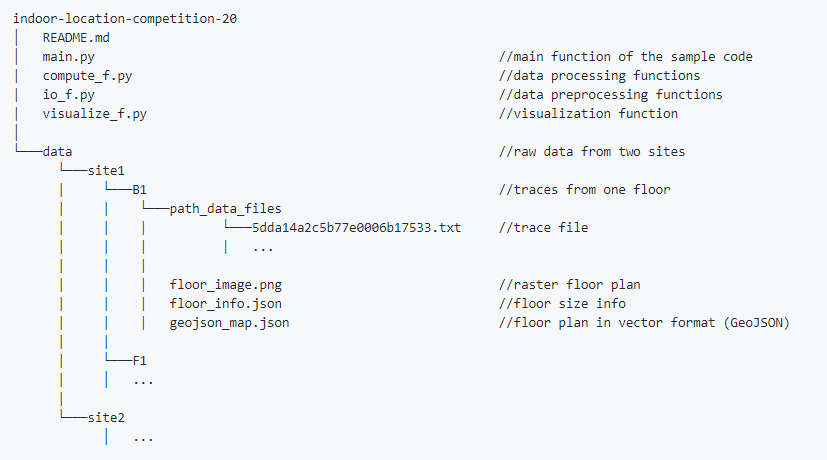

### Taking a Look at a Text File

In [ ]:
f = open("../input/indoor-location-navigation/test/00ff0c9a71cc37a2ebdd0f05.txt", "r")
print("Dataframe Info:\n")
for line in range(10):
    print(f.readline())

In [ ]:
print("Dataframe head in txt form:\n")
for line in range(5):
    print(f.readline())

# Understanding the Submission File and Output

Here I am going to explore the sample_submission.csv in depth. This should clear up any confusion about the output file.

In [ ]:
ss = pd.read_csv("../input/indoor-location-navigation/sample_submission.csv")
ss.head()

### Understanding The First Column: site_path_timestamp

In [ ]:
spt = ss.site_path_timestamp.values
spliter = lambda id_spt: id_spt.split('_')
spt = np.array([spliter(id_spt) for id_spt in spt])
spt = pd.DataFrame(spt, columns=["Site", "Path", "Timestamp"])
spt.head()

The site is the building id. The path is the id of a single walk that a person took. The timestamp is the time.

In [ ]:
test_sites = spt["Site"].unique()
len_sites = len(test_sites)
print(f"There are {len_sites} sites in the test(submission) file:") 
print(test_sites)
print()

test_paths = spt["Path"].unique()
len_paths = len(test_paths)
print(f"There are {len_paths} paths in the test(submission) file") 

If the timestamp look confusing to you, putting them into datetime form should clear up what it means. The test datasets do not have a date or month, so I will only display the time.

In [ ]:
spt['Datetime'] = pd.to_datetime(spt['Timestamp'].astype('int64'), unit='ms')
spt['Datetime'] = spt['Datetime'].apply( lambda d : d.time() ) 
spt.head(10)

### Floors

The floor map defined below can be used to convert between the train data floor labels and the numerical floor output you need in the test set.

In [ ]:
FLOOR_MAP = {"B2": -2, 
             "B1": -1, 
             "F1": 0, 
             "F2": 1, 
             "F3": 2, 
             "F4": 3, 
             "F5": 4, 
             "F6": 5, 
             "F7": 6, 
             "F8": 7, 
             "F9": 8,
             "1F": 0, "2F": 1, "3F": 2, "4F": 3, "5F": 4, "6F": 5, "7F": 6, "8F": 7, "9F": 8}

# Importing GitHub Scripts

By using this magical line of code you now are able to import classes and method from the preprocessing scripts on the GitHub Repo for this competition.
I also have the indoor-locationnavigation-2021 dataset which includes all the github scripts

In [ ]:
!git clone --depth 1 https://github.com/location-competition/indoor-location-competition-20 indoor_location_competition_20

### All Individual Imports

In [ ]:
from indoor_location_competition_20.io_f import read_data_file

In [ ]:
from indoor_location_competition_20.compute_f import split_ts_seq
from indoor_location_competition_20.compute_f import correct_trajectory
from indoor_location_competition_20.compute_f import correct_positions
from indoor_location_competition_20.compute_f import init_parameters_filter
from indoor_location_competition_20.compute_f import get_rotation_matrix_from_vector
from indoor_location_competition_20.compute_f import get_orientation
from indoor_location_competition_20.compute_f import compute_steps
from indoor_location_competition_20.compute_f import compute_stride_length
from indoor_location_competition_20.compute_f import compute_headings
from indoor_location_competition_20.compute_f import compute_step_heading
from indoor_location_competition_20.compute_f import compute_rel_positions
from indoor_location_competition_20.compute_f import compute_step_positions

I like to use the main and visualize functions from the indoor-locationnavigation-2021 dataset (they are almost exactly the same as the gitHub)

In [ ]:
!cp -r ../input/indoor-locationnavigation-2021/indoor-location-competition-20-master/indoor-location-competition-20-master/* ./

from main import calibrate_magnetic_wifi_ibeacon_to_position
from main import extract_magnetic_strength
from main import extract_wifi_rssi
from main import extract_ibeacon_rssi
from main import extract_wifi_count

In [ ]:
# GitHub functions
from visualize_f import visualize_trajectory
from visualize_f import visualize_heatmap

# Data Reader with io_f.py

Lets start by just reading in the data. For this, we will use the read_data_file from the io_f script.

In [ ]:
#ex_building = "5cd56b6fe2acfd2d33b5a386"
#ex_floor = "F1"
#ex_path = "5cf4f05d14ddfa0008131970"

ex_building = "5a0546857ecc773753327266"
ex_floor = "F4"
ex_path = "5d11dc28ffe23f0008604f67"

ex_file_path = f"../input/indoor-location-navigation/train/{ex_building}/{ex_floor}/{ex_path}.txt"

ex_file = open(ex_file_path, "r")
col_names = list()
for i in range(10):
    ex_file.readline()
    col_names.append(f"col_{i}")
ex_site = pd.read_csv(ex_file, names=col_names, delimiter='\t')
ex_site.head()

This is a mess. So what can we do to read in the data in a clean and usable format? Well the competitions io_f.py script contains functions effective at reading in the data.

In [ ]:
ex_db = read_data_file(ex_file_path) #create a sample database

print("Structure and Shape: ")
print("acce: {}".format(ex_db.acce.shape), "\n" +
      "acacce_uncalice: {}".format(ex_db.acce_uncali.shape), "\n" +
      "ahrs: {}".format(ex_db.ahrs.shape), "\n" +
      "gyro: {}".format(ex_db.gyro.shape), "\n" +
      "gyro_uncali: {}".format(ex_db.gyro_uncali.shape), "\n" +
      "ibeacon: {}".format(ex_db.ibeacon.shape), "\n" +
      "magn: {}".format(ex_db.magn.shape), "\n" +
      "magn_uncali: {}".format(ex_db.magn_uncali.shape), "\n" +
      "waypoint: {}".format(ex_db.waypoint.shape), "\n" +
      "wifi: {}".format(ex_db.wifi.shape))

I will be using these data frames throught this anaysis

In [ ]:
ex_acce = pd.DataFrame(ex_db.acce, columns=['time','x','y','z'])
ex_gyro = pd.DataFrame(ex_db.gyro, columns=['time','x','y','z'])
ex_magn = pd.DataFrame(ex_db.magn, columns=['time','x','y','z'])
ex_ahrs = pd.DataFrame(ex_db.ahrs, columns=['time','x','y','z'])

ex_waypoints = pd.DataFrame(ex_db.waypoint, columns=['time','X','Y'])

ex_acce.head()

In [ ]:
def plot_sensor_info(df, name):    
    cols = ["x", "y", "z"]
    plt.subplots(3, 3, sharex='col', sharey='row', figsize=(16,10))
    plt.suptitle(name, fontsize=22)
    for i in range(3):
        col=cols[i]
        plt.subplot(3, 3, i+1)
        sns.distplot(df[col], axlabel=col+"_axis")
        
        plt.subplot(3, 3, i+4)
        sns.boxplot(df[col], color="#96bcfa")
        
    plt.subplot(3, 1, 3)
    plt.plot(df['z'], color='#69cf83', label='z_axis')
    plt.plot(df['y'], color='#d6b258', label='y_axis')
    plt.plot(df['x'], color='#96bcfa', label='x_axis')
    plt.xlabel('Time')
    plt.ylabel('Sensor Value')
    plt.legend()
    plt.show()

In [ ]:
plot_sensor_info(ex_acce, "ACCE")

In [ ]:
plot_sensor_info(ex_gyro, "GYRO")

In [ ]:
plot_sensor_info(ex_magn, "MAGN")

In [ ]:
plot_sensor_info(ex_ahrs, "AHRS")

# Magnetic, WiFi, iBeacon (mwi) Dataset with main.py
The function below in the main function of the github can create a 
great dataset with magnetic, WiFi, and iBeacon data

In [ ]:
mwi = calibrate_magnetic_wifi_ibeacon_to_position([ex_file_path])

In [ ]:
mwi_df = pd.DataFrame(mwi).T
mwi_df.head()

Lets break this down and make it more understandable with the rest of the functions in main.py
### Magnetic Strength

In [ ]:
magnetic_strength = extract_magnetic_strength(mwi)

In [ ]:
magn_df = pd.DataFrame(magnetic_strength, index=[0]).T
magn_df.columns = ["magn"]
magn_df.head()

### WiFi

In [ ]:
wifi_rssi = extract_wifi_rssi(mwi)

Example of a BSSID WiFi Feature

In [ ]:
wifi_bssid = list(wifi_rssi.keys())
wifi_rssi_df = pd.DataFrame(dict(wifi_rssi[wifi_bssid[0]])).T
wifi_rssi_df.columns=["RSSI", "old_count"]
wifi_rssi_df.head()

WiFi Couunts

In [ ]:
wifi_counts = extract_wifi_count(mwi)

In [ ]:
wifi_counts_df = pd.DataFrame(wifi_counts, index=[0]).T
wifi_counts_df.columns = ["count"]
wifi_counts_df.head()

### iBeacon

In [ ]:
ibeacon_rssi = extract_ibeacon_rssi(mwi)

Example of an iBeacon ummid

In [ ]:
iBeacon_ummid = list(ibeacon_rssi.keys())
iBeacon_rssi_df = pd.DataFrame(dict(ibeacon_rssi[iBeacon_ummid[0]])).T
iBeacon_rssi_df.columns=["RSSI", "old_count"]
iBeacon_rssi_df.head()

# Visualizing with Visualize_f.py

### Visualize Floors of a Building

In [ ]:
def show_site_png(site):
    '''This functions outputs the visualization of the .png images available
    in the metadata.
    sites: the code coresponding to 1 site (or building)'''
    
    base = '../input/indoor-location-navigation'
    site_path = f"{base}/metadata/{site}/*/floor_image.png"
    floor_paths = glob.glob(site_path)
    n = len(floor_paths)

    # Create the custom number of rows & columns
    ncols = [ceil(n / 3) if n > 4 else 4][0]
    nrows = [ceil(n / ncols) if n > 4 else 1][0]

    plt.figure(figsize=(20, 10))
    plt.suptitle(f"Site no. '{site}'", fontsize=18)

    # Plot image for each floor
    for k, floor in enumerate(floor_paths):
        plt.subplot(nrows, ncols, k+1)

        image = Image.open(floor)

        plt.imshow(image)
        plt.axis("off")
        title = floor.split("/")[5]
        plt.title(title, fontsize=15)
        

In [ ]:
#This site has a lot of floors so it is a good example
show_site_png(site='5cd56b64e2acfd2d33b592b3')

### Visualize Waypoints

In [ ]:
trajectory = ex_db.waypoint
trajectory = trajectory[:, 1:3]

ex_png_path = f"../input/indoor-location-navigation/metadata/{ex_building}/{ex_floor}/floor_image.png"
ex_json_path = f"../input/indoor-location-navigation/metadata/{ex_building}/{ex_floor}/floor_info.json"

with open(ex_json_path) as json_file:
    json_data = json.load(json_file)
    
width_meter = json_data["map_info"]["width"]
height_meter = json_data["map_info"]["height"]

visualize_trajectory(trajectory = trajectory,
                     floor_plan_filename = ex_png_path,
                     width_meter=width_meter,
                     height_meter=height_meter,
                     title="Waypoint Path",
                     g_size=750,
                     point_color='#76C1A0',
                     start_color='#007B51',
                     end_color='#9B0000')

### Visualize Magnetic Strength

In [ ]:
heat_positions = np.array(list(magnetic_strength.keys()))
heat_values = np.array(list(magnetic_strength.values()))

visualize_heatmap(heat_positions, 
                  heat_values, 
                  ex_png_path,
                  width_meter, 
                  height_meter, 
                  colorbar_title='strength', 
                  title='Magnetic Strength',
                  g_size=750,
                  colorscale='temps')


### Visualize WiFi

In [ ]:
heat_positions = np.array(list(wifi_counts.keys()))
heat_values = np.array(list(wifi_counts.values()))
# filter out positions that no wifi detected
mask = heat_values != 0
heat_positions = heat_positions[mask]
heat_values = heat_values[mask]

# The heatmap
visualize_heatmap(heat_positions, 
                  heat_values, 
                  ex_png_path, 
                  width_meter, 
                  height_meter, 
                  colorbar_title=' WiFi Counts', 
                  title=f'WiFi Count',
                  g_size=755,
                  colorscale='temps')


In [ ]:
print(f'This floor has {len(wifi_rssi.keys())} wifis.')

wifi_bssid = list(wifi_rssi.keys())
target_wifi = wifi_bssid[0]
heat_positions = np.array(list(wifi_rssi[target_wifi].keys()))
heat_values = np.array(list(wifi_rssi[target_wifi].values()))[:, 0]

# The heatmap
visualize_heatmap(heat_positions, 
                  heat_values, 
                  ex_png_path, 
                  width_meter, 
                  height_meter, 
                  colorbar_title='dBm', 
                  title=f'WiFi RSSI ({target_wifi})',
                  g_size=755,
                  colorscale='temps')

### Visualize iBeacon

In [ ]:
print(f'This floor has {len(ibeacon_rssi.keys())} ibeacons.')

ibeacon_ummids = list(ibeacon_rssi.keys())
target_ibeacon = ibeacon_ummids[0]
heat_positions = np.array(list(ibeacon_rssi[target_ibeacon].keys()))
heat_values = np.array(list(ibeacon_rssi[target_ibeacon].values()))[:, 0]

# The heatmap
visualize_heatmap(heat_positions, 
                  heat_values, 
                  ex_png_path, 
                  width_meter, 
                  height_meter, 
                  colorbar_title='dBm', 
                  title=f'iBeacon RSSI ({target_ibeacon})',
                  g_size=755,
                  colorscale='temps')

# Computing with compute_f.py

In [ ]:
sensor_df = pd.DataFrame()

### Compute Steps
Takes in acce_datas from io_f.py. Computes the step_acce max, min, and std.

In [ ]:
step_timestamps, step_indexs, step_acce_max_mins = compute_steps(ex_db.acce)

In [ ]:
sensor_df = pd.DataFrame(step_acce_max_mins, index=step_indexs)
sensor_df.columns = ["timestamp", "acce_max", "acce_min", "acce_std"]
sensor_df.head()

### Compute Stride Length
Takes in step_acce_max_min from compute_steps. Computes stride length.

In [ ]:
stride_lengths = compute_stride_length(step_acce_max_mins)

In [ ]:
sensor_df["stride_length"] = stride_lengths[:, 1]
sensor_df.head()

### Compute Headings and Compute Step Headings
Takes in ahrs_datas from io_f.py. Computes headings.

Takes in step_timestamps from compute_steps and headings from compute_headings. Computes step headings.

In [ ]:
headings = compute_headings(ex_db.ahrs)

In [ ]:
headings.shape

In [ ]:
step_headings = compute_step_heading(step_timestamps, headings)

In [ ]:
sensor_df["step_heading"] = step_headings[:, 1]
sensor_df.head()

### Compute Rel Positions
Takes in stride_lengths from compute_stride_length and step_headings from compute_step_headings. Computes relative positions

In [ ]:
rel_positions = compute_rel_positions(stride_lengths, step_headings)

In [ ]:
sensor_df["rel_pos_x"] = rel_positions[:, 1]
sensor_df["rel_pos_y"] = rel_positions[:, 2]
sensor_df.head()

### Compute Step Positions
Takes in acce_datas, ahrs_datas, and posi_datas from io_f.py. Computes step positions.

In [ ]:
step_positions = compute_step_positions(ex_db.acce, ex_db.ahrs, ex_db.waypoint)

In [ ]:
sensor_df["step_pos_x"] = step_positions[:, 1]
sensor_df["step_pos_y"] = step_positions[:, 2]
sensor_df.head()

### Examining our Computed Values

In [ ]:
#Fix timestamp
def time_float_to_str(time):
    return str(int(time))

sensor_df["timestamp"] = sensor_df["timestamp"].apply(time_float_to_str)
sensor_df

In [ ]:
def plot_sensor_info(df, name='Computed Sensor Info'):
    plt.subplots(6, 2, figsize=(18,24))
    plt.suptitle(name, fontsize=22)
    
    plt.subplot(6, 1, 1)
    plt.plot(df['acce_max'], color='#db5046', label='acce_max')
    plt.plot(df['acce_min'], color='#96bcfa', label='acce_min')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('ACCE Max & Min Over Time')
    plt.legend(loc='upper left')
    
    plt.subplot(6, 2, 3)
    plt.title('ACCE Max Boxplot')
    sns.boxplot(df['acce_min'], color="#db5046").set(xlabel=None)
    
    plt.subplot(6, 2, 4)
    plt.title('ACCE Min Boxplot')
    sns.boxplot(df['acce_min'], color="#96bcfa").set(xlabel=None)
    
    plt.subplot(6, 1, 3)
    plt.plot(df['stride_length'], color='#69cf83')
    plt.xlabel('Time')
    plt.ylabel('Length')
    plt.title('Stride Length Over Time')
    
    plt.subplot(6, 2 , 7)
    sns.distplot(df['acce_std'], color='#eba834', axlabel='acce_std')
    plt.title('acce_std')
    
    plt.subplot(6, 2, 8)
    sns.distplot(df['step_heading'], color='#34c8ed', axlabel='step_heading')
    plt.title('step_heading')
    
    plt.subplot(6, 1, 5)
    plt.plot(df['rel_pos_x'], color='#96bcfa', label='rel_pos_x')
    plt.plot(df['rel_pos_y'], color='#db5046', label='rel_pos_y')
    plt.legend(loc='upper left')
    plt.title('rel_pos')
    
    plt.subplot(6, 1, 6)
    plt.plot(df['step_pos_x'], color='#96bcfa', label='step_pos_x')
    plt.plot(df['step_pos_y'], color='#db5046', label='step_pos_y')
    plt.legend(loc='upper left')
    plt.title('step_pos')
    
    plt.show()

In [ ]:
plot_sensor_info(sensor_df)

In [ ]:
sensor_df.describe()

# Final Thoughts

I did not include the split_ts_seq, correct_trajectory or correct_positions although I may add these in the future. I actually indirectly used them by calling other functions which called them. I also did not include init_parameters_filter, get_rotation_matrix_from_vector, and get_orientation as I am still figuring out how to properly use them. If you have any advice on how to use these functions comment below.

Let me know if I used any function incorrectly or if I could improve in any way. 

I hope you find this notebook helpful in understanding the GitHub functions and comment how you plan to use these functions. Good luck!